## Step1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet import UNet

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [9]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to use different preprocessing

In [10]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"


# pre-defined split
with open('../train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=test_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [11]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

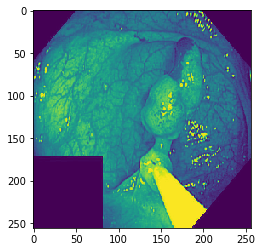

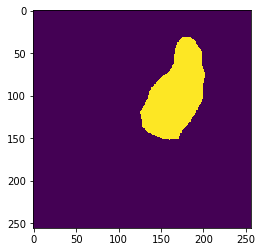

In [12]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [13]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [14]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

## Pipeline

In [15]:
def train(model, optim, criterion, dataloader, epoch, device):
    pass

In [16]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    pass

# Training hyperparameters

In [17]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [18]:
# Define variables for the training
epochs = 50

In [19]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_baseline'

criterion = IoULoss()
model_name = 'UNet_IoULoss_baseline'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_baseline'


# Training

In [20]:
# train_losses = []
# val_losses = []
# best_iou = 0
# best_loss = np.Inf
# best_epoch = -1


# for epoch in range(epochs):
#     running_loss = 0
#     running_iou = 0
#     # Train
#     model.train()
#     for i, (imgs, masks) in enumerate(dataloader_train):
#         imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
#         prediction = model(imgs)
        
#         optimiser.zero_grad()
#         loss = criterion(prediction, masks)
#         loss.backward()
#         optimiser.step()
        
#         running_loss += loss.item()
#         print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
#         running_iou += iou_pytorch_eval(prediction, masks)
#         print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
#     # Validate
#     model.eval()
#     val_loss = 0
#     val_iou = 0
#     for i, (imgs, masks) in enumerate(dataloader_val):
#         imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
#         prediction = model(imgs)
#         loss = criterion(prediction, masks)
#         val_loss += loss.item()
#         print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
#         val_iou += iou_pytorch_eval(prediction, masks)
#         print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
#     # compute overall epoch losses
#     epoch_train_loss = running_loss/len(dataloader_train)
#     train_losses.append(epoch_train_loss)
#     epoch_val_loss = val_loss/len(dataloader_val)
#     val_losses.append(epoch_val_loss)
#     # compute overall epoch iou-s
#     epoch_train_iou = running_iou/len(dataloader_train)
#     epoch_val_iou = val_iou/len(dataloader_val)
    
#     print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_val_loss))
#     print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_iou, epoch_val_iou))
    
    
#     # plot 
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}')
#     plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()
    
#     # save if best results
#     best_iou = max(best_iou, epoch_val_iou)
#     best_loss = min(best_loss, epoch_val_loss)
#     best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
#     if best_epoch == epoch:
#         # print('Saving..')
#         state = {
#             'net': model.state_dict(),
#             'iou': best_iou,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [21]:
# best_epoch, best_iou

In [22]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()

## Evaluate validation performance (256*256 images)

In [23]:
%ls ../checkpoints

ckpt_UNet_BCEWithLogitsLoss_baseline.pth  ckpt_UNet_IoULoss_augmented.pth
ckpt_UNet_IoUBCELoss_baseline.pth         ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoULoss_attention.pth           README.md


In [138]:
# model_name = 'UNet_IoULoss_baseline'
# model_name = 'UNet_BCELoss_baseline'
model_name = 'UNet_IoUBCELoss_baseline'


# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

<All keys matched successfully>

In [139]:
print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
print(f'Validation IoU ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'].item())

Best epoch: 47
Validation IoU (256x256): 0.6735328435897827
